<a href="https://colab.research.google.com/github/KVasanth-17/pai-internal/blob/main/IML_PROJECT_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter any city name: NALGONDA
Mean Squared Error for Rain Model: 0.136986301369863

⛅ City: NALGONDA, IN
Current Temperature: 37°C
Feels Like: 35°C
Min Temperature: 37°C, Max Temperature: 37°C
Humidity: 20%
Weather Description: Few clouds
Rain Prediction: ☀️ No Rain Expected

Future Temperature Predictions:
19:00: 33.2°C
20:00: 24.5°C
21:00: 24.5°C
22:00: 24.5°C
23:00: 24.5°C

Future Humidity Predictions:
19:00: 20.1%
20:00: 20.1%
21:00: 20.1%
22:00: 20.1%
23:00: 20.1%


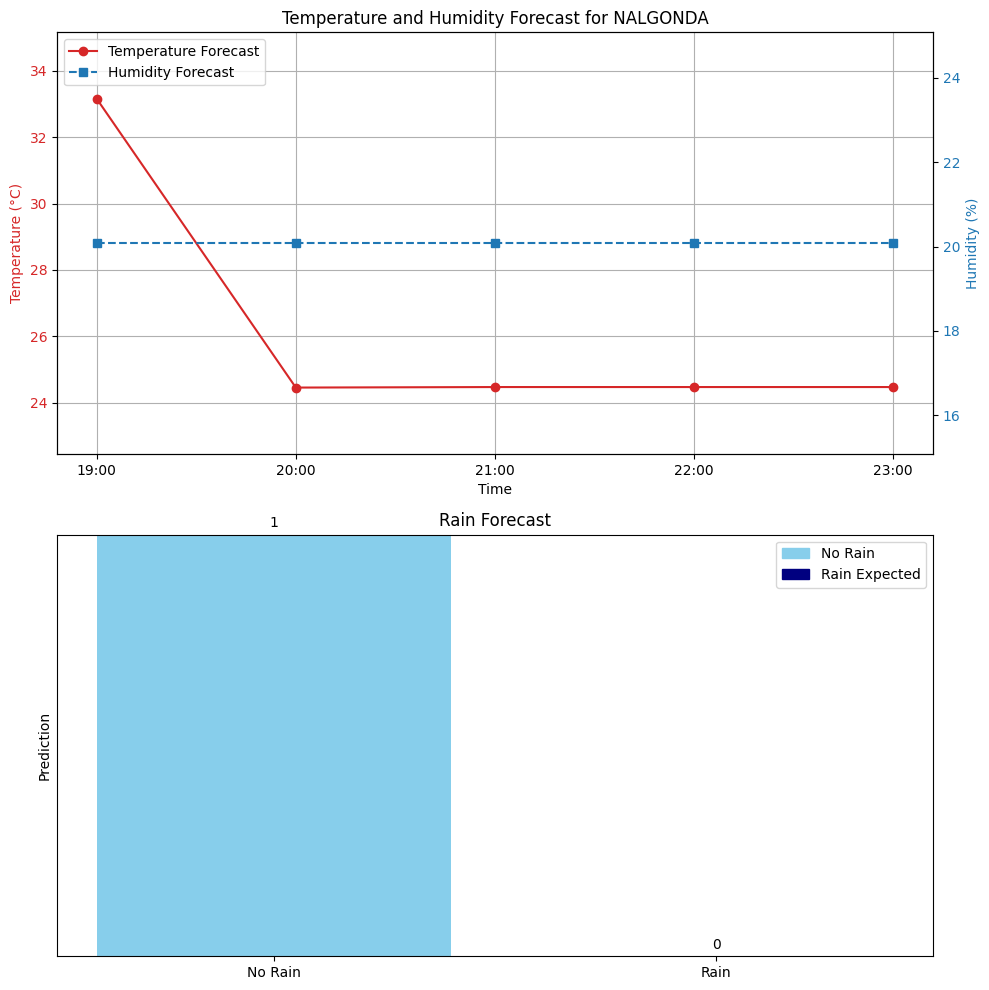

In [4]:
from IPython.display import display
import matplotlib.pyplot as plt
from IPython.display import display
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
import pytz
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

API_KEY = 'feb831f004c9a44f2e6df3c3513c7eaf'
BASE_URL = 'https://api.openweathermap.org/data/2.5/'

def get_current_weather(city):
    url = f"{BASE_URL}weather?q={city}&appid={API_KEY}&units=metric"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Error: {response.json().get('message', 'Unknown error')}")
        return None

    data = response.json()
    return {
        'city': data['name'],
        'current_temp': round(data['main']['temp']),
        'feels_like': round(data['main']['feels_like']),
        'temp_min': round(data['main']['temp_min']),
        'temp_max': round(data['main']['temp_max']),
        'humidity': round(data['main']['humidity']),
        'description': data['weather'][0]['description'],
        'country': data['sys']['country'],
        'wind_gust_dir': data['wind'].get('deg', 0),
        'pressure': data['main']['pressure'],
        'WindGustSpeed': data['wind']['speed']
    }

def read_historical_data(filepath='/content/weather.csv'):
    df = pd.read_csv(filepath).dropna().drop_duplicates()
    return df

def prepare_data(df):
    le = LabelEncoder()
    df['WindGustDir'] = le.fit_transform(df['WindGustDir'])
    df['RainTomorrow'] = le.fit_transform(df['RainTomorrow'])

    features = df[['MinTemp', 'MaxTemp', 'WindGustDir', 'WindGustSpeed', 'Humidity', 'Pressure', 'Temp']]
    target = df['RainTomorrow']
    return features, target, le

def train_rain_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print("Mean Squared Error for Rain Model:", mean_squared_error(y_test, predictions))
    return model

def prepare_regression_data(df, column):
    X, y = [], []
    for i in range(len(df)-1):
        X.append([df[column].iloc[i]])
        y.append(df[column].iloc[i+1])
    return np.array(X), np.array(y)

def train_regression_model(X, y):
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X, y)
    return model

def predict_future(model, start_value, steps=5):
    predictions = [start_value]
    for _ in range(steps):
        next_val = model.predict([[predictions[-1]]])[0]
        predictions.append(next_val)
    return predictions[1:]  # <-- Add this import


def weather_icon(description):
    """Return an emoji based on weather description."""
    description = description.lower()
    if 'rain' in description:
        return "🌧️"
    elif 'cloud' in description:
        return "⛅"
    elif 'clear' in description:
        return "☀️"
    elif 'snow' in description:
        return "❄️"
    elif 'storm' in description:
        return "⛈️"
    else:
        return "🌡️"

def weather_view():
    city = input("Enter any city name: ")
    current = get_current_weather(city)
    if not current:
        return

    df = read_historical_data('/content/weather.csv')
    X, y, le = prepare_data(df)
    rain_model = train_rain_model(X, y)

    # Encode wind direction
    wind_deg = current['wind_gust_dir'] % 360
    compass_points = [
        ("N", 348.75, 360), ("N", 0, 11.25), ("NNE", 11.25, 33.75), ("NE", 33.75, 56.25),
        ("ENE", 56.25, 78.75), ("E", 78.75, 101.25), ("ESE", 101.25, 123.75),
        ("SE", 123.75, 146.25), ("SSE", 146.25, 168.75), ("S", 168.75, 191.25),
        ("SSW", 191.25, 213.75), ("SW", 213.75, 236.25), ("WSW", 236.25, 258.75),
        ("W", 258.75, 281.25), ("WNW", 281.25, 303.75), ("NW", 303.75, 326.25),
        ("NNW", 326.25, 348.75)
    ]
    compass = next(cp for cp, start, end in compass_points if start <= wind_deg < end)
    encoded_dir = le.transform([compass])[0] if compass in le.classes_ else -1

    current_df = pd.DataFrame([{
        'MinTemp': current['temp_min'],
        'MaxTemp': current['temp_max'],
        'WindGustDir': encoded_dir,
        'WindGustSpeed': current['WindGustSpeed'],
        'Humidity': current['humidity'],
        'Pressure': current['pressure'],
        'Temp': current['current_temp']
    }])

    rain_prediction = rain_model.predict(current_df)[0]

    X_temp, y_temp = prepare_regression_data(df, 'Temp')
    X_hum, y_hum = prepare_regression_data(df, 'Humidity')

    temp_model = train_regression_model(X_temp, y_temp)
    hum_model = train_regression_model(X_hum, y_hum)

    future_temp = predict_future(temp_model, current['current_temp'])
    future_hum = predict_future(hum_model, current['humidity'])

    timezone = pytz.timezone('Asia/Kolkata')
    now = datetime.now(timezone)
    future_times = [(now + timedelta(hours=i+1)).strftime("%H:00") for i in range(5)]

    # Display Current Weather
    icon = weather_icon(current['description'])

    print(f"\n{icon} City: {city}, {current['country']}")
    print(f"Current Temperature: {current['current_temp']}°C")
    print(f"Feels Like: {current['feels_like']}°C")
    print(f"Min Temperature: {current['temp_min']}°C, Max Temperature: {current['temp_max']}°C")
    print(f"Humidity: {current['humidity']}%")
    print(f"Weather Description: {current['description'].capitalize()}")
    print(f"Rain Prediction: {'🌧️ Rain Expected' if rain_prediction else '☀️ No Rain Expected'}")

    print("\nFuture Temperature Predictions:")
    for t, val in zip(future_times, future_temp):
        print(f"{t}: {round(val, 1)}°C")

    print("\nFuture Humidity Predictions:")
    for t, val in zip(future_times, future_hum):
        print(f"{t}: {round(val, 1)}%")

    # --- Matplotlib Visualization ---
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # Line plot for Temperature and Humidity
    ax1 = axs[0]
    color = 'tab:red'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Temperature (°C)', color=color)
    ax1.plot(future_times, future_temp, marker='o', color=color, label='Temperature Forecast')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(min(future_temp)-2, max(future_temp)+2)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Humidity (%)', color=color)
    ax2.plot(future_times, future_hum, marker='s', linestyle='--', color=color, label='Humidity Forecast')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(min(future_hum)-5, max(future_hum)+5)

    ax1.set_title(f"Temperature and Humidity Forecast for {city}")
    ax1.grid(True)
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left')

    # Bar chart for Rain Prediction
    ax3 = axs[1]
    rain_labels = ['No Rain', 'Rain']
    rain_values = [1, 0] if rain_prediction == 0 else [0, 1]
    bars = ax3.bar(rain_labels, rain_values, color=['skyblue', 'navy'])

    # Custom colors and legend
    no_rain_patch = mpatches.Patch(color='skyblue', label='No Rain')
    rain_patch = mpatches.Patch(color='navy', label='Rain Expected')

    ax3.set_ylim(0, 1)
    ax3.set_ylabel('Prediction')
    ax3.set_title('Rain Forecast')
    ax3.legend(handles=[no_rain_patch, rain_patch])

    # Remove y-ticks for cleaner look
    ax3.set_yticks([])

    # Add labels above bars
    for bar in bars:
        height = bar.get_height()
        ax3.annotate(f'{int(height)}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Run
weather_view()

